# Train-test of single PINN poisson

In [48]:
from xpinn import XPINN
import optax
from type_util import Array
from jax import hessian, jacobian, jit, vmap
import jax.numpy as np
import numpy as onp
import sys
from tqdm import tqdm
from utils import data_path
from base_network import neural_network
from poisson.poisson_utils import boundary_loss_factory, interior_loss_factory, crude_rel_L2, interface_loss_factory
from jax.nn import sigmoid
import plotutils

In [49]:
## Run meshing
%run XPINN_points.py
%run XPINN_test_points.py

(657, 2)
(243, 2)


In [50]:
file = data_path / "poisson_train.json"
file_test = data_path / "poisson_test.json"
activation = np.tanh

### Set model (FFNN)
xpinn = XPINN(file, activation)
model = neural_network(activation)
v_model = vmap(model, (None, 0))

In [51]:
# Set losses
def rhs(x):
    return np.where((x[0]>= 0.25) &(x[0]<=0.75)&(x[1]>= 0.25) &(x[1]<=0.75), -1,0)

p0, p1 = xpinn.PINNs
p0.boundary_loss = boundary_loss_factory(p0,0.0, weight=20)
p0.interior_loss = interior_loss_factory(p0, rhs)  # implementing rhs
p1.interior_loss = interior_loss_factory(p1, rhs)
p0.interface_loss = interface_loss_factory(xpinn,0, 1, weight=20)
p1.interface_loss = interface_loss_factory(xpinn,1, 0, weight=20)

In [52]:
### Initializing optimizer
shapes =[[2, 20, 20, 20, 20, 20, 20, 20, 1],[2, 20, 20, 20, 20, 20, 20, 20, 1]]
exponential_decay = optax.exponential_decay(
        init_value=0.001,
        transition_steps=10000,
        transition_begin=15000,
        decay_rate=0.1,
        end_value=0.0000001,
    )
optimizer = optax.adam(learning_rate=exponential_decay)
xpinn.initialize_params(shapes, optimizer)
xpinn.set_loss()

In [53]:
n_iter = 200000
losses = xpinn.run_iters(n_iter)

0.00% iter = 0 of 200000: Total loss = 4.189557194709778
10.00% iter = 20000 of 200000: Total loss = 0.06476818397641182
20.00% iter = 40000 of 200000: Total loss = 0.03640669025480747
30.00% iter = 60000 of 200000: Total loss = 0.03400383610278368
40.00% iter = 80000 of 200000: Total loss = 0.033058823086321354
50.00% iter = 100000 of 200000: Total loss = 0.03206119779497385
60.00% iter = 120000 of 200000: Total loss = 0.031028402037918568
70.00% iter = 140000 of 200000: Total loss = 0.02997525967657566
80.00% iter = 160000 of 200000: Total loss = 0.028914482332766056
90.00% iter = 180000 of 200000: Total loss = 0.02782848384231329
100.00% iter = 200000 of 200000: Total loss = 0.02670981828123331


Text(0.5, 1.0, 'Loss per Pinn over 200000 epochs')

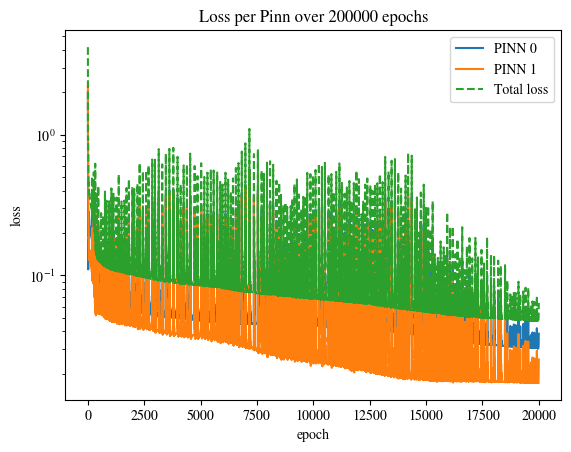

In [54]:
import matplotlib.pyplot as plt
a_losses = losses
t_0 = 0
t_end = min(20000, n_iter)
t = np.arange(t_0, t_end)

for i in range(2):
    plt.plot(t, a_losses[i, t_0:t_end], label=f"PINN {i}")
plt.plot(t, np.sum(a_losses, axis=0)[t_0:t_end], "--", label="Total loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.yscale("log")
plt.legend()
plt.title(f"Loss per Pinn over {n_iter} epochs")

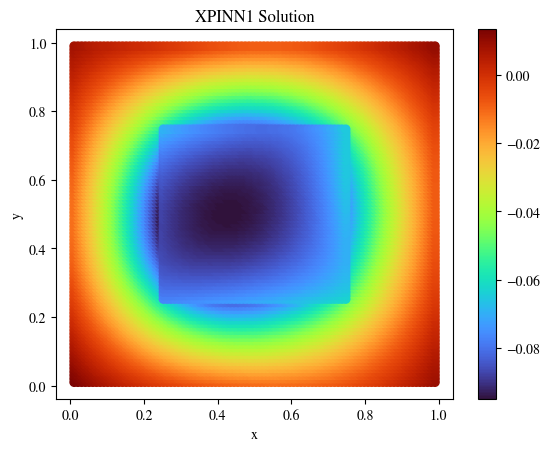

In [61]:
points, predictions = xpinn.predict(file_test)
total_pred = np.concatenate(predictions)
total_points = np.concatenate(points)

sorted_indices = np.lexsort((total_points[:,1],total_points[:,0]))
sorted_pred = total_pred[sorted_indices]
sorted_points = total_points[sorted_indices]

min_, max_ = total_pred.min(), total_pred.max()


#plt.scatter(sorted_points[:, 0], sorted_points[:, 1], c=sorted_pred, cmap="turbo")
plt.scatter(total_points[:, 0], total_points[:, 1], c=total_pred, cmap="turbo")
plt.xlabel("x")
plt.ylabel("y")
plt.title("XPINN1 Solution")
#plt.clim(min_, max_)

plt.colorbar()

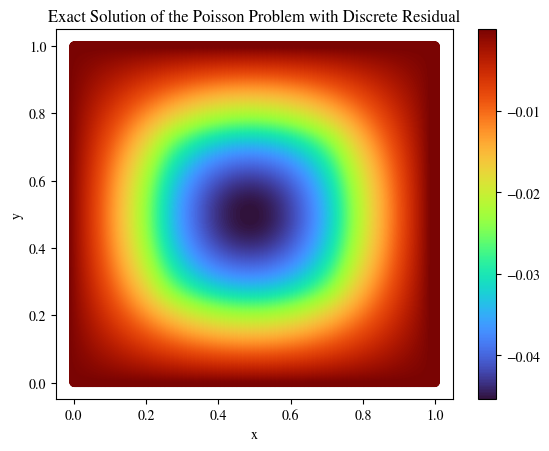

In [56]:
file = f"../true_solution.npz"
with onp.load(file) as true_file:
    true_sol = true_file["arr_0"]

plt.scatter(sorted_points[:, 0], sorted_points[:, 1], c=true_sol, cmap="turbo")
plt.title("Exact Solution of the Poisson Problem with Discrete Residual")
plt.xlabel("x")
plt.ylabel("y")
plt.colorbar()

In [62]:
plt.scatter(sorted_points[:, 0], sorted_points[:, 1], c=true_sol-sorted_pred, cmap="turbo")
plt.title("Exact Solution of the Poisson Problem with Discrete Residual")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Absolute Error for the XPINN Solution")
plt.colorbar()

TypeError: sub got incompatible shapes for broadcasting: (996004, 1), (9604, 1).